In [2]:
import pandas as pd               #For data loading and data manipulation
import seaborn as sns             #For data visualization 
import matplotlib.pyplot as plt   #For data visualization
%matplotlib inline
import re

import nltk
from nltk.corpus import stopwords #For stopword removals

import string                     #For Punctuations

import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb



In [3]:
# Display.max_colwidth option  set to None to show all text content without truncation
pd.set_option('display.max_colwidth', None)

# Your code to read the DataFrame
df1 = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')
df=pd.concat([df1,test_df])

In [3]:
df.head(10)

,sentiment,message,tweetid
0,1.0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1.0,It's not like we lack evidence of anthropogenic global warming,126103
2,2.0,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954
5,1.0,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j,425577
6,1.0,RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R,294933
7,1.0,"RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦",992717
8,1.0,"@AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.",664510
9,1.0,RT @paigetweedy: no offense… but like… how do you just not believe… in global warming………,260471


From the data snippet shown above, we see that the message column contains some noise (stop words, puntuations, mentions, hashtags and even urls). We need to deal with the noise before proceeding to analyze the data.

In [4]:
df.shape

(26365, 3)

In [5]:
df.info() #Let's see our datatypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26365 entries, 0 to 10545
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  15819 non-null  float64
 1   message    26365 non-null  object 
 2   tweetid    26365 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 823.9+ KB


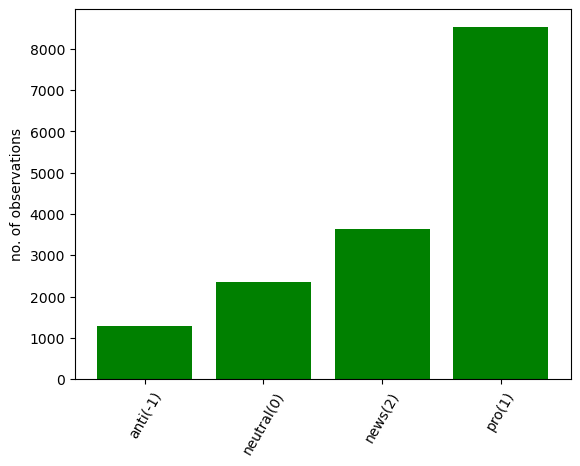

In [7]:
# Separate minority and majority classes
news = df1[df1['sentiment']== 2]
pro = df1[df1['sentiment']== 1]
neutral = df1[df1['sentiment']== 0]
anti = df1[df1['sentiment']== -1]

labels = df1['sentiment'].unique()
heights = [len(news),len(pro), len(neutral), len(anti)]
plt.bar(labels,heights,color='green')
plt.xticks(labels,['news(2)','pro(1)', 'neutral(0)', 'anti(-1)'], rotation = 60)
plt.ylabel("no. of observations")
plt.show()

## **DATA PREPROCESSING**

### **Remove Stop words**

In [8]:
df_train = df.copy() #Let us make a copy of our dataframe to avoid modifying the original dataframe

In [9]:
#To get a list of english stopwords
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
 clean_texts = []

for text in df_train['message']:
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)
    clean_texts.append(clean_text)

# clean_texts
df_train['clean_message'] = clean_texts
df_train.head()

,sentiment,message,tweetid,clean_message
0,1.0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,"PolySciMajor EPA chief think carbon dioxide main cause global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"
1,1.0,It's not like we lack evidence of anthropogenic global warming,126103,like lack evidence anthropogenic global warming
2,2.0,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,RT @RawStory: Researchers say three years act climate change it’s late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,#TodayinMaker# WIRED : 2016 pivotal year war climate change https://t.co/44wOTxTLcD
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,"RT @SoyNovioDeTodas: 2016, racist, sexist, climate change denying bigot leading polls. #ElectionNight"


**QUESTION**
Should we drop the original message column at this point? Or would it be useful for future reference?

### **Remove Urls**

In [11]:
#Remove urls and replace with 'url'
 
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'

subs_url = r'url'

df_train['clean_message'] = df_train['clean_message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [12]:
df_train['clean_message'].iloc[2]

'RT @RawStory: Researchers say three years act climate change it’s late url url…'

### **Remove Punctuation**

In [13]:
#Convert message to lower case
df_train['clean_message'] = df_train['clean_message'].str.lower()

print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [14]:
def remove_punctuation(message):
    return ''.join([l for l in message if l not in string.punctuation])


df_train['clean_message'] = df_train['clean_message'].apply(remove_punctuation)
df_train['clean_message'].iloc[9]

'rt paigetweedy offense… like… believe… global warming………'

In [15]:
df_train['clean_message'].iloc[2]

'rt rawstory researchers say three years act climate change it’s late url url…'

Despite removing puntuations, we still observe some curly quotation marks and repeated punctuations.

Let's deal with these using regular expression(regex)

In [16]:
def clean_text(text):
    text = re.sub(r'[^\w\s"“”]', '', text)  # Remove non-alphanumeric characters and curly quotation marks
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = re.sub(r'([!?.])\1+', r'\1', text)  # Remove repeated punctuation marks
    return text.strip()

# Apply the clean_text function to the 'message' column
df_train['clean_message'] = df_train['clean_message'].apply(clean_text)
df_train['clean_message'].iloc[2]

'rt rawstory researchers say three years act climate change its late url url'

In [16]:
df_train['clean_message'].iloc[9]

'rt paigetweedy offense like believe global warming'

Looks like our data has been delivered of every noise.......

In [17]:
df_train.shape

(26365, 4)

In [18]:
df_train=df_train.drop(["message"],axis=1)

In [19]:
df_train.head()

,sentiment,tweetid,clean_message
0,1.0,625221,polyscimajor epa chief think carbon dioxide main cause global warming and wait what url via mashable
1,1.0,126103,like lack evidence anthropogenic global warming
2,2.0,698562,rt rawstory researchers say three years act climate change its late url url
3,1.0,573736,todayinmaker wired 2016 pivotal year war climate change url
4,1.0,466954,rt soynoviodetodas 2016 racist sexist climate change denying bigot leading polls electionnight


### Tokenization

In [20]:
tokeniser = TreebankWordTokenizer()
df_train['tokenize'] = df_train['clean_message'].apply(tokeniser.tokenize)
df_train

,sentiment,tweetid,clean_message,tokenize
0,1.0,625221,polyscimajor epa chief think carbon dioxide main cause global warming and wait what url via mashable,"[polyscimajor, epa, chief, think, carbon, dioxide, main, cause, global, warming, and, wait, what, url, via, mashable]"
1,1.0,126103,like lack evidence anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, warming]"
2,2.0,698562,rt rawstory researchers say three years act climate change its late url url,"[rt, rawstory, researchers, say, three, years, act, climate, change, its, late, url, url]"
3,1.0,573736,todayinmaker wired 2016 pivotal year war climate change url,"[todayinmaker, wired, 2016, pivotal, year, war, climate, change, url]"
4,1.0,466954,rt soynoviodetodas 2016 racist sexist climate change denying bigot leading polls electionnight,"[rt, soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]"
...,...,...,...,...
10541,NaN,895714,rt brittanybohrer brb writing poem climate change climatechange science poetry fakenews alternativefacts url,"[rt, brittanybohrer, brb, writing, poem, climate, change, climatechange, science, poetry, fakenews, alternativefacts, url]"
10542,NaN,875167,2016 year climate change came home hottest year record karl mathiesen travelled tasmania url,"[2016, year, climate, change, came, home, hottest, year, record, karl, mathiesen, travelled, tasmania, url]"
10543,NaN,78329,rt loopvanuatu pacific countries positive fiji leading global climate change conference november url,"[rt, loopvanuatu, pacific, countries, positive, fiji, leading, global, climate, change, conference, november, url]"
10544,NaN,867455,rt xanria00018 youre hot must cause global warming aldublaboroflove jophie30 asn585,"[rt, xanria00018, youre, hot, must, cause, global, warming, aldublaboroflove, jophie30, asn585]"


### Lematization

In [21]:
lemmatizer = WordNetLemmatizer()
def lemma(words, lemmatizer):
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

# df_train['lemmatized'] = df_train['tokenize'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])



In [22]:
df_train['lemmatized'] = df_train['tokenize'].apply(lemma, args=(lemmatizer, ))


In [61]:
df_train 

,sentiment,tweetid,clean_message,tokenize,lemmatized
0,1.0,625221,polyscimajor epa chief think carbon dioxide main cause global warming and wait what url via mashable,"[polyscimajor, epa, chief, think, carbon, dioxide, main, cause, global, warming, and, wait, what, url, via, mashable]",polyscimajor epa chief think carbon dioxide main cause global warming and wait what url via mashable
1,1.0,126103,like lack evidence anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, warming]",like lack evidence anthropogenic global warming
2,2.0,698562,rt rawstory researchers say three years act climate change its late url url,"[rt, rawstory, researchers, say, three, years, act, climate, change, its, late, url, url]",rt rawstory researcher say three year act climate change it late url url
3,1.0,573736,todayinmaker wired 2016 pivotal year war climate change url,"[todayinmaker, wired, 2016, pivotal, year, war, climate, change, url]",todayinmaker wired 2016 pivotal year war climate change url
4,1.0,466954,rt soynoviodetodas 2016 racist sexist climate change denying bigot leading polls electionnight,"[rt, soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]",rt soynoviodetodas 2016 racist sexist climate change denying bigot leading poll electionnight
...,...,...,...,...,...
10541,NaN,895714,rt brittanybohrer brb writing poem climate change climatechange science poetry fakenews alternativefacts url,"[rt, brittanybohrer, brb, writing, poem, climate, change, climatechange, science, poetry, fakenews, alternativefacts, url]",rt brittanybohrer brb writing poem climate change climatechange science poetry fakenews alternativefacts url
10542,NaN,875167,2016 year climate change came home hottest year record karl mathiesen travelled tasmania url,"[2016, year, climate, change, came, home, hottest, year, record, karl, mathiesen, travelled, tasmania, url]",2016 year climate change came home hottest year record karl mathiesen travelled tasmania url
10543,NaN,78329,rt loopvanuatu pacific countries positive fiji leading global climate change conference november url,"[rt, loopvanuatu, pacific, countries, positive, fiji, leading, global, climate, change, conference, november, url]",rt loopvanuatu pacific country positive fiji leading global climate change conference november url
10544,NaN,867455,rt xanria00018 youre hot must cause global warming aldublaboroflove jophie30 asn585,"[rt, xanria00018, youre, hot, must, cause, global, warming, aldublaboroflove, jophie30, asn585]",rt xanria00018 youre hot must cause global warming aldublaboroflove jophie30 asn585


In [23]:
###drop unwanted columns
df_train = df_train.drop(['tokenize'], axis =1)
df_train = df_train.drop(['clean_message'], axis =1)

In [25]:
df_train

,sentiment,tweetid,lemmatized
0,1.0,625221,polyscimajor epa chief think carbon dioxide main cause global warming and wait what url via mashable
1,1.0,126103,like lack evidence anthropogenic global warming
2,2.0,698562,rt rawstory researcher say three year act climate change it late url url
3,1.0,573736,todayinmaker wired 2016 pivotal year war climate change url
4,1.0,466954,rt soynoviodetodas 2016 racist sexist climate change denying bigot leading poll electionnight
...,...,...,...
10541,NaN,895714,rt brittanybohrer brb writing poem climate change climatechange science poetry fakenews alternativefacts url
10542,NaN,875167,2016 year climate change came home hottest year record karl mathiesen travelled tasmania url
10543,NaN,78329,rt loopvanuatu pacific country positive fiji leading global climate change conference november url
10544,NaN,867455,rt xanria00018 youre hot must cause global warming aldublaboroflove jophie30 asn585


# CountVectorizer

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
vect = CountVectorizer()
vect.fit(df_train['lemmatized'])

CountVectorizer()

In [28]:
df_train.head()

,sentiment,tweetid,lemmatized
0,1.0,625221,polyscimajor epa chief think carbon dioxide main cause global warming and wait what url via mashable
1,1.0,126103,like lack evidence anthropogenic global warming
2,2.0,698562,rt rawstory researcher say three year act climate change it late url url
3,1.0,573736,todayinmaker wired 2016 pivotal year war climate change url
4,1.0,466954,rt soynoviodetodas 2016 racist sexist climate change denying bigot leading poll electionnight


In [29]:
vect = CountVectorizer(stop_words='english')

In [30]:
vect = CountVectorizer(ngram_range=(1, 2))

In [31]:
vect = CountVectorizer(max_df=0.5)

In [32]:
vect = CountVectorizer(min_df=2)

In [33]:
betterVect = CountVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.5, 
                             ngram_range=(1, 1))

In [34]:
df_new=betterVect.fit_transform(df_train['lemmatized'])

In [35]:
betterVect

CountVectorizer(max_df=0.5, min_df=2, stop_words='english')

In [36]:
df_train

,sentiment,tweetid,lemmatized
0,1.0,625221,polyscimajor epa chief think carbon dioxide main cause global warming and wait what url via mashable
1,1.0,126103,like lack evidence anthropogenic global warming
2,2.0,698562,rt rawstory researcher say three year act climate change it late url url
3,1.0,573736,todayinmaker wired 2016 pivotal year war climate change url
4,1.0,466954,rt soynoviodetodas 2016 racist sexist climate change denying bigot leading poll electionnight
...,...,...,...
10541,NaN,895714,rt brittanybohrer brb writing poem climate change climatechange science poetry fakenews alternativefacts url
10542,NaN,875167,2016 year climate change came home hottest year record karl mathiesen travelled tasmania url
10543,NaN,78329,rt loopvanuatu pacific country positive fiji leading global climate change conference november url
10544,NaN,867455,rt xanria00018 youre hot must cause global warming aldublaboroflove jophie30 asn585


In [37]:
print(df_new)

  (0, 3693)	1
  (0, 1964)	1
  (0, 10230)	1
  (0, 1724)	1
  (0, 3097)	1
  (0, 6353)	1
  (0, 1785)	1
  (0, 4516)	1
  (0, 10991)	1
  (0, 10960)	1
  (0, 10780)	1
  (0, 6469)	1
  (1, 4516)	1
  (1, 10991)	1
  (1, 6162)	1
  (1, 5965)	1
  (1, 3784)	1
  (1, 794)	1
  (2, 10780)	2
  (2, 8344)	1
  (2, 8621)	1
  (2, 8978)	1
  (2, 11348)	1
  (2, 380)	1
  (2, 6004)	1
  :	:
  (26362, 6045)	1
  (26362, 2542)	1
  (26362, 7153)	1
  (26362, 2356)	1
  (26362, 7451)	1
  (26362, 7900)	1
  (26362, 4085)	1
  (26363, 1785)	1
  (26363, 4516)	1
  (26363, 10991)	1
  (26363, 5065)	1
  (26363, 11379)	1
  (26363, 584)	1
  (26363, 11313)	1
  (26363, 5726)	1
  (26363, 947)	1
  (26364, 4516)	1
  (26364, 5545)	1
  (26364, 10134)	1
  (26364, 7760)	1
  (26364, 3508)	1
  (26364, 3445)	1
  (26364, 11258)	1
  (26364, 4480)	1
  (26364, 1154)	1


In [38]:
df["sentiment"].values

array([ 1.,  1.,  2., ..., nan, nan, nan])

In [39]:
y=df_train[:len(df1)][["sentiment"]]
y

,sentiment
0,1.0
1,1.0
2,2.0
3,1.0
4,1.0
...,...
15814,1.0
15815,2.0
15816,0.0
15817,-1.0


In [40]:
X_train=df_new[:len(df1)]
print(X_train)

  (0, 3693)	1
  (0, 1964)	1
  (0, 10230)	1
  (0, 1724)	1
  (0, 3097)	1
  (0, 6353)	1
  (0, 1785)	1
  (0, 4516)	1
  (0, 10991)	1
  (0, 10960)	1
  (0, 10780)	1
  (0, 6469)	1
  (1, 4516)	1
  (1, 10991)	1
  (1, 6162)	1
  (1, 5965)	1
  (1, 3784)	1
  (1, 794)	1
  (2, 10780)	2
  (2, 8344)	1
  (2, 8621)	1
  (2, 8978)	1
  (2, 11348)	1
  (2, 380)	1
  (2, 6004)	1
  :	:
  (15815, 10780)	1
  (15815, 1503)	1
  (15815, 11013)	1
  (15815, 8524)	1
  (15815, 89)	1
  (15816, 10780)	1
  (15816, 1236)	1
  (15816, 10501)	1
  (15816, 8736)	1
  (15816, 7640)	1
  (15816, 5698)	1
  (15816, 544)	1
  (15816, 404)	1
  (15816, 7208)	1
  (15817, 4938)	1
  (15817, 1878)	1
  (15817, 5004)	1
  (15817, 6133)	1
  (15817, 2581)	1
  (15817, 10295)	1
  (15817, 514)	1
  (15817, 8947)	1
  (15817, 1648)	1
  (15818, 10780)	1
  (15818, 3705)	1


In [41]:
y["sentiment"].values

array([ 1.,  1.,  2., ...,  0., -1.,  0.])

In [42]:
X_TEST=df_new[len(df1):]

In [43]:
X_TEST.shape

(10546, 11458)

Now our parameters are y,X_train,X_TEST

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y["sentiment"].values, test_size=0.2, random_state=42)

# Scaling

In [46]:
from sklearn.preprocessing import StandardScaler

# Scale the tweet vectors
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_TEST_scaled= scaler.transform(X_TEST)

# Support Vector Machine

In [47]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print("The accuracy score of the SVC is:", accuracy_score(y_test, y_pred))
print("\n\nClassification Report:\n\n", classification_report(y_test, y_pred))

The accuracy score of the SVC is: 0.7196586599241467


Classification Report:

               precision    recall  f1-score   support

        -1.0       0.59      0.50      0.54       278
         0.0       0.45      0.53      0.49       425
         1.0       0.80      0.78      0.79      1755
         2.0       0.76      0.76      0.76       706

    accuracy                           0.72      3164
   macro avg       0.65      0.64      0.65      3164
weighted avg       0.72      0.72      0.72      3164



In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

svc = SVC(kernel='linear')
svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)

print("The accuracy score of the SVC is:", accuracy_score(y_test, y_pred))
print("\n\nClassification Report:\n\n", classification_report(y_test, y_pred))

The accuracy score of the SVC is: 0.5989254108723135


Classification Report:

               precision    recall  f1-score   support

        -1.0       0.38      0.49      0.43       278
         0.0       0.33      0.49      0.40       425
         1.0       0.75      0.63      0.69      1755
         2.0       0.63      0.63      0.63       706

    accuracy                           0.60      3164
   macro avg       0.52      0.56      0.54      3164
weighted avg       0.64      0.60      0.61      3164



It was noticed that training with unscaled data led to higher training accuracy but lower test accuracy. Inshort scale ur data. Thanks

# GridSearch Using SVC

In [87]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
# Create a pipeline with CountVectorizer and SVC
vectorizer = CountVectorizer()
pipeline = Pipeline([
    ('svc', SVC())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

KeyboardInterrupt: 

# Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
lr = LogisticRegression(max_iter=1000)

In [90]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [91]:
pred_lr = lr.predict(X_test_scaled)

In [93]:
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test, pred_lr, target_names=['0: Neutral', '1: ProClimate','2: News','-1:AntiClimate']))

print("The accuracy score of the SVC is:", accuracy_score(y_test, pred_lr))


Classification Report
                precision    recall  f1-score   support

    0: Neutral       0.55      0.46      0.50       278
 1: ProClimate       0.39      0.49      0.44       425
       2: News       0.76      0.72      0.74      1755
-1:AntiClimate       0.67      0.70      0.69       706

      accuracy                           0.66      3164
     macro avg       0.59      0.59      0.59      3164
  weighted avg       0.67      0.66      0.67      3164

The accuracy score of the SVC is: 0.6630847029077117


# Naive Bayes

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_scaled, y_train)

MultinomialNB()

In [50]:
# Make predictions on the testing data
y_pred = nb_classifier.predict(X_test_scaled)


In [51]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6419089759797725


# Neural Network

In [52]:
from sklearn.neural_network import MLPClassifier
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train_scaled, y_train)

MLPClassifier()

In [53]:
mlp_predictions = mlp_classifier.predict(X_test_scaled)


In [54]:
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)

MLP Accuracy: 0.690897597977244


# RNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Assuming you have already prepared your training and testing data: X_trainrnn, X_testrnn, y_train, y_test

# Convert sparse input data to dense arrays
X_trainrnn = X_train_scaled.toarray()
X_testrnn = X_test_scaled.toarray()

# Determine the number of unique tokens in your input data
num_tokens = int(np.max([np.max(X_trainrnn[i, :]) for i in range(X_trainrnn.shape[0])]) + 1)

model = Sequential()
model.add(Embedding(input_dim=num_tokens, output_dim=32))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_trainrnn, y_train, batch_size=8, epochs=10, verbose=1)

# Evaluate the model
_, accuracy = model.evaluate(X_testrnn, y_test)
print("RNN Accuracy:", accuracy)


Epoch 1/10
1083/1582 [===================>..........] - ETA: 3:30:48 - loss: 0.2792 - accuracy: 0.5347

# Transfomers

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import TFBertModel, BertTokenizer
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Assuming X_train_scaled, X_test_scaled, y_train, and y_test are available

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Convert input data to list of strings
X_train_texts = [str(seq) for seq in X_train_scaled]
X_test_texts = [str(seq) for seq in X_test_scaled]

# Tokenize and pad the input sequences
input_ids = tokenizer.batch_encode_plus(X_train_texts, padding='longest', truncation=True, return_tensors='tf')['input_ids']
input_ids_test = tokenizer.batch_encode_plus(X_test_texts, padding='longest', truncation=True, return_tensors='tf')['input_ids']

# Build the model architecture
input_layer = Input(shape=(input_ids.shape[1],), dtype=tf.int32)
bert_output = bert_model(input_layer)[0][:, 0, :]
output_layer = Dense(1, activation='sigmoid')(bert_output)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(input_ids, y_train, batch_size=8, epochs=3, verbose=1)

# Evaluate the model
predictions = model.predict(input_ids_test)
predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(y_test, predictions)
print("Transformers Accuracy:", accuracy)


# Random Forest

In [55]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)

# Train the classifier
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [56]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test_scaled)


In [57]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

Random Forest Accuracy: 0.7035398230088495


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Define your random forest classifier
rf_classifier = RandomForestClassifier()

# Define the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 300, 400, 500]}

# Perform grid search using cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X, y)  # X is your feature matrix, y is your target variable

# Get the best parameter value
best_n_estimators = grid_search.best_params_['n_estimators']


# Random Forest with Grid Search

In [60]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier()

# Perform grid search to find the best parameters
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)




C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [61]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params)
best_rf_classifier.fit(X_train_scaled, y_train)


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.705807981035164


RandomForestClassifier(min_samples_split=5, n_estimators=200)

In [62]:
# Make predictions on the testing data
y_pred = best_rf_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

Random Forest Accuracy: 0.7221871049304678


# XGBoost Classifier

In [76]:
y_trainint=[int(i) for i in y_train]
y_testint=[int(i) for i in y_test]

# Map the labels to [0, 1, 2, 3] instead of 0,-1,2,



                         

In [77]:
label_mapping_train = {label: idx for idx, label in enumerate(np.unique(y_trainint))}
labels_train = np.array([label_mapping_train[label] for label in y_trainint])

In [78]:
label_mapping_test = {label: idx for idx, label in enumerate(np.unique(y_testint))}
labels_test = np.array([label_mapping_test[label] for label in y_testint])

In [79]:
import xgboost as xgb
# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier()



# Train the classifier
xgb_classifier.fit(X_train_scaled, labels_train)

# Make predictions on the testing data
y_pred_test = xgb_classifier.predict(X_test_scaled)

#Now we convert changed prediction labels back

# Define inverse mapping dictionaries
inv_label_mapping_train = {idx: label for label, idx in label_mapping_train.items()}
inv_label_mapping_test = {idx: label for label, idx in label_mapping_test.items()}
y_pred_original_test = np.array([inv_label_mapping_test[pred] for pred in y_pred_test])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_original_test)
print("XGBoost Accuracy:", accuracy)

XGBoost Accuracy: 0.7104930467762326


# XGBoost Classifier using Gridsearch CV

In [80]:
# Define the parameter grid for grid search 
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Perform grid search to find the best parameters
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_params)
best_xgb_classifier.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred_test = best_xgb_classifier.predict(X_test_scaled)

#Now we convert changed prediction labels back

# Define inverse mapping dictionaries
inv_label_mapping_train = {idx: label for label, idx in label_mapping_train.items()}
inv_label_mapping_test = {idx: label for label, idx in label_mapping_test.items()}
y_pred_original_test = np.array([inv_label_mapping_test[pred] for pred in y_pred_test])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_original_test)
print("XGBoost Accuracy:", accuracy)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)

ValueError: 
All the 540 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DELL\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got [-1.  0.  1.  2.]


In [63]:
### preparing result for submission
# result=lr.predict(X_TEST_scaled)
# res = svc.predict(X_TEST_scaled)
res = best_rf_classifier.predict(X_TEST_scaled)


In [64]:
# result=[int(i) for i in result]
res=[int(i) for i in res]

In [65]:
res

[2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 -1,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 1,
 2,
 -1,
 -1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 -1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 -1,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 -1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 2,
 1,
 -1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 -1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 -1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,

In [66]:
# DAF=pd.DataFrame(result,columns=["sentiment"])
# DAF.head()
DAF=pd.DataFrame(res,columns=["sentiment"])
DAF.shape

(10546, 1)

In [67]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, res)
print("Accuracy:", accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [3164, 10546]

In [68]:
output=pd.DataFrame({"tweetid":test_df["tweetid"]})
submission=output.join(DAF)
submission

,tweetid,sentiment
0,169760,2
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,0


In [69]:
submission.to_csv("submission.csv",index=False)